# Covid-19

El brote de una nueva cepa de coronavirus, identificado como 2019-nCoV, fue reportado por primera vez en la ciudad de Wuhan, China, a finales de diciembre de 2019. Este virus, posteriormente denominado SARS-CoV-2, generó una pandemia global con efectos sanitarios, sociales y económicos sin precedentes. La enfermedad causada por este virus, conocida como COVID-19, mostró una rápida propagación a nivel mundial a partir de enero de 2020, afectando tanto a países desarrollados como en vías de desarrollo.

El presente proyecto tiene como objetivo analizar la evolución de la pandemia en Colombia, utilizando datos abiertos de casos diarios confirmados, muertes, recuperaciones y casos activos. Para ello, se trabajará con un subconjunto del conjunto de datos global proporcionado por la comunidad de ciencia de datos, el cual recopila datos desde las primeras etapas de la pandemia.

Este conjunto de datos fue recopilado originalmente de fuentes confiables como la Organización Mundial de la Salud (OMS) y el sitio web Worldometers, y se encuentra disponible públicamente en plataformas como Kaggle, como en nuestro caso, el dataset se llama **COVID-19 Dataset**. Específicamente, el archivo utilizado para esta etapa del análisis es **covid_19_clean_complete.csv**, el cual contiene información a nivel país y por fecha. 

Se hará un filtrado de la información correspondiente exclusivamente a Colombia, el conjunto de datos (después de haberlo explorado) se observa que cubre el periodo entre enero de 2020 y julio de 2020.

Las principales variables incluidas en este conjunto de datos son:

- Date: Fecha del reporte.

- Country/Region: País correspondiente al registro (en este caso, Colombia).

- Confirmed: Número acumulado de casos confirmados hasta la fecha.

- Deaths: Número acumulado de muertes asociadas al COVID-19.

- Recovered: Número acumulado de pacientes recuperados.

- Active: Casos activos (calculado como Confirmed - Deaths - Recovered).

Este análisis se orientará como un problema de **regresión**, cuyo objetivo es predecir el comportamiento futuro de alguna de las variables mencionadas, por ejemplo, el número de casos confirmados o muertes, en función de valores pasados. Para ello, se aplicarán modelos, con una evaluación rigurosa de su desempeño. Para este Notebook se tomará el numero de casos confirmados y se haran las predicciones sobre el mismo, aunque de igual manera, se dejara indicado la manera en la cual poder crear un dataframe con cualquiera de las otras variables.

## Librerias Requeridas

In [1]:
import pandas as pd 
import numpy as np

import matplotlib.pyplot as plt 
import seaborn as sns

from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import TimeSeriesSplit
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.neural_network import MLPRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error

import warnings

## Carga De datos

In [2]:
df = pd.read_csv('Data/covid_19_clean_complete.csv')
df

,Province/State,Country/Region,Lat,Long,Date,Confirmed,Deaths,Recovered,Active,WHO Region
0,NaN,Afghanistan,33.939110,67.709953,2020-01-22,0,0,0,0,Eastern Mediterranean
1,NaN,Albania,41.153300,20.168300,2020-01-22,0,0,0,0,Europe
2,NaN,Algeria,28.033900,1.659600,2020-01-22,0,0,0,0,Africa
3,NaN,Andorra,42.506300,1.521800,2020-01-22,0,0,0,0,Europe
4,NaN,Angola,-11.202700,17.873900,2020-01-22,0,0,0,0,Africa
...,...,...,...,...,...,...,...,...,...,...
49063,NaN,Sao Tome and Principe,0.186400,6.613100,2020-07-27,865,14,734,117,Africa
49064,NaN,Yemen,15.552727,48.516388,2020-07-27,1691,483,833,375,Eastern Mediterranean
49065,NaN,Comoros,-11.645500,43.333300,2020-07-27,354,7,328,19,Africa
49066,NaN,Tajikistan,38.861000,71.276100,2020-07-27,7235,60,6028,1147,Europe


## Filtrado de los Datos y EDA

In [3]:
df_Colombia = df[df['Country/Region'] == 'Colombia'].copy()
df_Colombia

,Province/State,Country/Region,Lat,Long,Date,Confirmed,Deaths,Recovered,Active,WHO Region
81,NaN,Colombia,4.5709,-74.2973,2020-01-22,0,0,0,0,Americas
342,NaN,Colombia,4.5709,-74.2973,2020-01-23,0,0,0,0,Americas
603,NaN,Colombia,4.5709,-74.2973,2020-01-24,0,0,0,0,Americas
864,NaN,Colombia,4.5709,-74.2973,2020-01-25,0,0,0,0,Americas
1125,NaN,Colombia,4.5709,-74.2973,2020-01-26,0,0,0,0,Americas
...,...,...,...,...,...,...,...,...,...,...
47844,NaN,Colombia,4.5709,-74.2973,2020-07-23,226373,7688,107951,110734,Americas
48105,NaN,Colombia,4.5709,-74.2973,2020-07-24,233541,7975,113864,111702,Americas
48366,NaN,Colombia,4.5709,-74.2973,2020-07-25,240795,8269,119667,112859,Americas
48627,NaN,Colombia,4.5709,-74.2973,2020-07-26,240795,8269,119667,112859,Americas


Aca podemos observar algo muy claro, y es la limitación en el tamaño del conjunto de datos: Con solo 188 puntos de datos, la capacidad del modelo para capturar patrones complejos, como tendencias a largo plazo o estacionalidades sutiles, es limitada. Esto puede afectar la precisión de las predicciones, especialmente si los datos contienen fluctuaciones. A pesar de la cantidad relativamente pequeña de datos, se realizó un análisis utilizando modelos de regresión, lo que permitió obtener una aproximación a las predicciones

In [4]:
df_Colombia.info()

<class 'pandas.core.frame.DataFrame'>
Index: 188 entries, 81 to 48888
Data columns (total 10 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Province/State  0 non-null      object 
 1   Country/Region  188 non-null    object 
 2   Lat             188 non-null    float64
 3   Long            188 non-null    float64
 4   Date            188 non-null    object 
 5   Confirmed       188 non-null    int64  
 6   Deaths          188 non-null    int64  
 7   Recovered       188 non-null    int64  
 8   Active          188 non-null    int64  
 9   WHO Region      188 non-null    object 
dtypes: float64(2), int64(4), object(4)
memory usage: 16.2+ KB


Aca se puede apreciar facilemente que columnas como *Province/State, Lat, Long y WHO Region* **NO** son columnas que aporten datos relevantes para el análisis, por ende, se descartarán.

In [5]:
df_Colombia.isnull().sum()

Province/State    188
Country/Region      0
Lat                 0
Long                0
Date                0
Confirmed           0
Deaths              0
Recovered           0
Active              0
WHO Region          0
dtype: int64

In [6]:
df_Colombia.describe()

,Lat,Long,Confirmed,Deaths,Recovered,Active
count,1.880000e+02,1.880000e+02,188.000000,188.000000,188.000000,188.000000
mean,4.570900e+00,-7.429730e+01,36665.542553,1258.111702,15020.271277,20387.159574
std,8.905501e-16,1.424880e-14,61000.321766,2091.025748,27977.236028,31239.401632
min,4.570900e+00,-7.429730e+01,0.000000,0.000000,0.000000,0.000000
25%,4.570900e+00,-7.429730e+01,1.000000,0.000000,0.000000,1.000000
50%,4.570900e+00,-7.429730e+01,5011.500000,229.000000,1035.000000,3747.500000
75%,4.570900e+00,-7.429730e+01,44064.500000,1446.750000,16766.000000,25851.750000
max,4.570900e+00,-7.429730e+01,257101.000000,8777.000000,131161.000000,117163.000000


## Visualización de los Datos

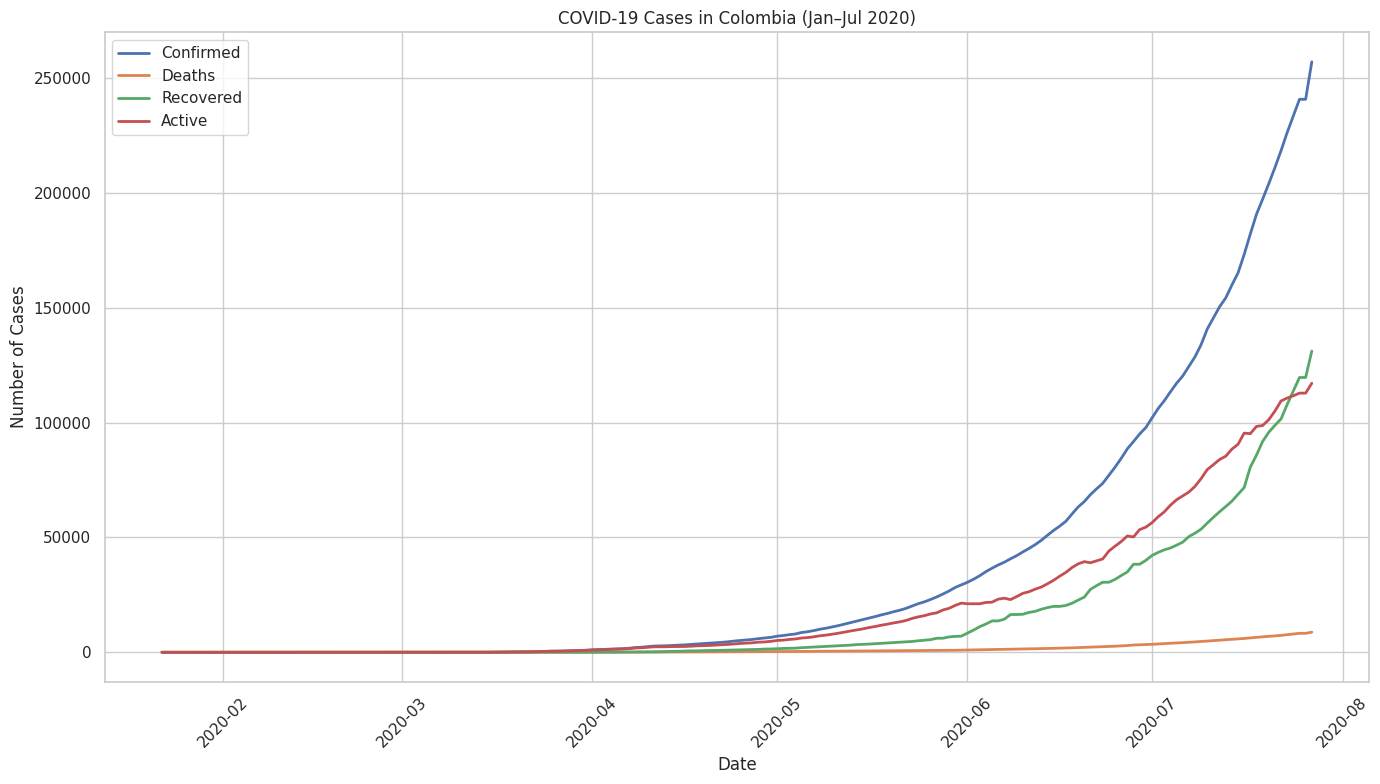

In [7]:
df_Colombia['Date'] = pd.to_datetime(df_Colombia['Date'])
sns.set(style="whitegrid")
plt.figure(figsize=(14, 8))

#each metric
plt.plot(df_Colombia['Date'], df_Colombia['Confirmed'], label = 'Confirmed', linewidth = 2)
plt.plot(df_Colombia['Date'], df_Colombia['Deaths'], label = 'Deaths', linewidth = 2)
plt.plot(df_Colombia['Date'], df_Colombia['Recovered'], label = 'Recovered', linewidth = 2)
plt.plot(df_Colombia['Date'], df_Colombia['Active'], label = 'Active', linewidth = 2)


plt.title('COVID-19 Cases in Colombia (Jan–Jul 2020)')
plt.xlabel('Date')
plt.ylabel('Number of Cases')
plt.legend()
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

Esta primera grafica permite visualizar de forma integrada la evolucion acumulada de los casos confirmados, muertes, recuperados y casos activos de COVID-19 en Colombia durante los primeros siete meses del año 2020.

Se observa un crecimiento exponencial en el número total de contagios a partir de mayo, acompañado de un aumento constante tanto en los recuperados como en los casos activos. La línea de casos activos (en rojo) se mantiene cercana a la de recuperados, indicando que durante gran parte del brote, la proporción de personas aún infectadas fue significativa.

Por otro lado, la curva de fallecimientos (en naranja) muestra una pendiente más suave y sostenida, evidenciando que aunque la letalidad es una fracción menor respecto a los contagios, su crecimiento también ha sido constante a lo largo del tiempo.

Esta representación global resulta útil para identificar relaciones proporcionales y momentos clave del brote, asi como poder apreciar aceleraciones y estabilizaciones durante el primer semestre de COVID-19 en Colombia, ademas, sirve como base principal para establecer decisiones en modelos predictivos.

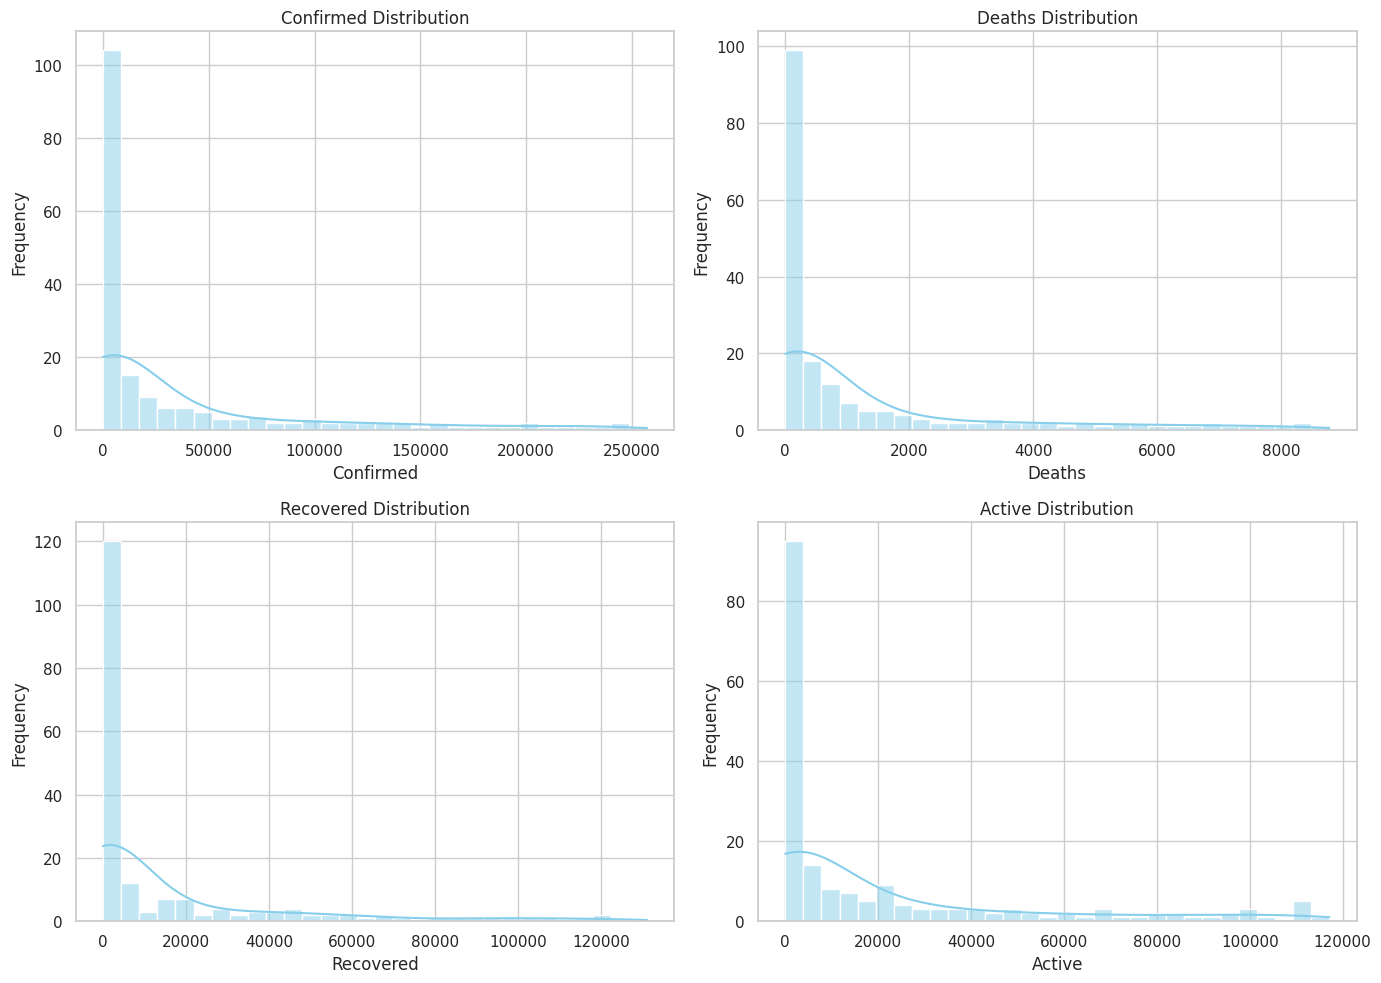

In [8]:
metrics = ['Confirmed', 'Deaths', 'Recovered', 'Active']

plt.figure(figsize=(14, 10))
for i, metric in enumerate(metrics, 1):
    plt.subplot(2, 2, i)
    sns.histplot(df_Colombia[metric], kde = True, bins = 30, color = 'skyblue')
    plt.title(f'{metric} Distribution')
    plt.xlabel(metric)
    plt.ylabel('Frequency')

plt.tight_layout()
plt.show()

Todas las distribuciones presentan un comportamiento altamente asimétrico a la derecha, es decir, una distribución sesgada, lo que indica que la mayoría de los días se reportaron volúmenes bajos de casos o muertes, mientras que pocos días concentraron los picos más altos.

De estas graficas se puede inducir que: 

- La distribución de casos confirmados muestra una larga cola derecha, con pocos días superando los 50.000 casos.

- En las muertes, se presenta un patrón similar, aunque con un rango mucho menor.

Este comportamiento sugiere que, para ciertos modelos de regresión, podría ser conveniente aplicar transformaciones de normalización para mejorar la estabilidad numérica y la capacidad de generalización de los modelos.

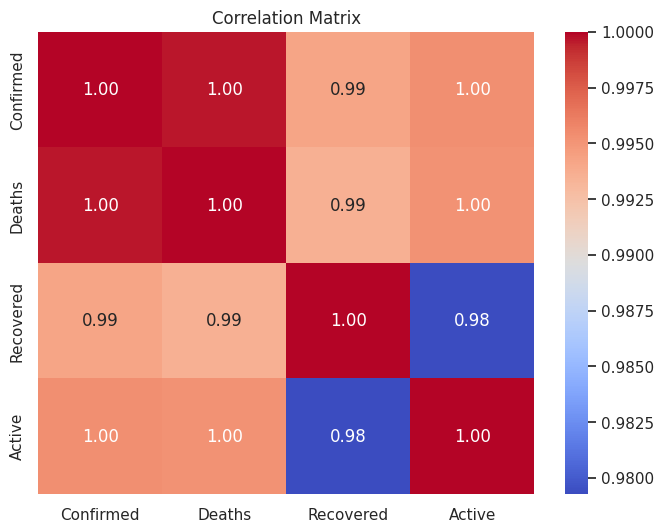

In [9]:
plt.figure(figsize=(8, 6))
corr = df_Colombia[['Confirmed', 'Deaths', 'Recovered', 'Active']].corr()
sns.heatmap(corr, annot = True, cmap = 'coolwarm', fmt = ".2f")
plt.title('Correlation Matrix')
plt.show()

Esta matriz de correlación permite observar la relación lineal entre las principales variables del conjunto de datos: casos confirmados, muertes, recuperados y activos. Se observa una alta correlación positiva entre todas las variables, especialmente entre:

- Confirmed y Deaths: 1.00

- Confirmed y Recovered: 0.99

- Deaths y Recovered: 0.99

Esto indica que estas variables evolucionan de manera conjunta y que comparten un fuerte componente común, derivado de su naturaleza acumulativa. Aunque es esperable, es importante tenerlo en cuenta para evitar colinealidad en modelos predictivos.

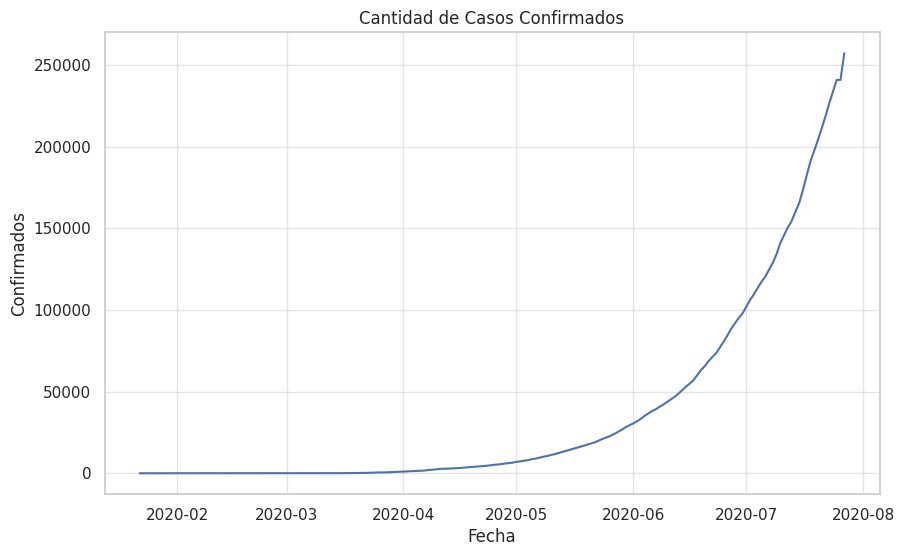

In [10]:
plt.figure(figsize=(10, 6))
plt.title("Cantidad de Casos Confirmados")
sns.lineplot(df_Colombia, x = df_Colombia["Date"], y = df_Colombia['Confirmed'])
plt.xlabel("Fecha")
plt.ylabel("Confirmados")
plt.grid(True, alpha = 0.5)
plt.show()

Esta gráfica muestra el comportamiento de los casos confirmados en Colombia desde febrero hasta finales de julio de 2020. Se evidencia un crecimiento exponencial, especialmente a partir del mes de junio, lo cual refleja el avance acelerado de la pandemia en el país.
El cambio en la pendiente a partir de mayo indica el inicio de un crecimiento mucho más rápido, posiblemente asociado a la expansión del virus y al aumento en la capacidad de detección diagnóstica. Esta tendencia refuerza la necesidad de modelos predictivos capaces de capturar curvas de crecimiento no lineales.

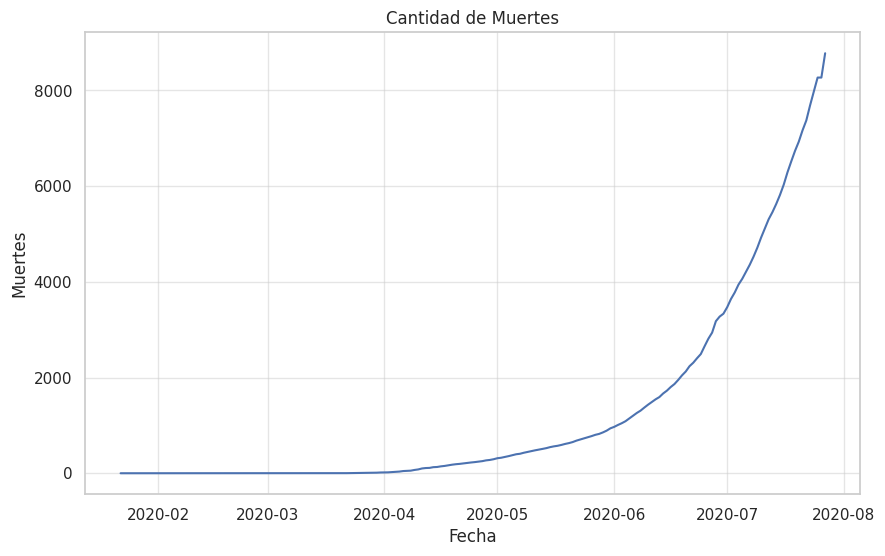

In [11]:
plt.figure(figsize=(10, 6))
plt.title("Cantidad de Muertes")
sns.lineplot(df_Colombia, x = df_Colombia["Date"], y = df_Colombia['Deaths'])
plt.xlabel("Fecha")
plt.ylabel("Muertes")
plt.grid(True, alpha = 0.5)
plt.show()

La gráfica muestra la progresión acumulada del número de muertes en Colombia desde febrero hasta finales de julio de 2020. Se evidencia una fase inicial de crecimiento lento (febrero–abril), seguida de una aceleración progresiva y sostenida a partir de mayo, que culmina en un crecimiento exponencial claro durante junio y julio.

Este comportamiento refleja cómo la propagación del virus se intensificó con el paso del tiempo, especialmente durante los meses en los que se empezaron a relajar las medidas de confinamiento en varias regiones. La pendiente creciente indica que la cantidad diaria de fallecimientos fue aumentando de manera constante, lo que plantea desafíos importantes en la salud. Esta tendencia también pone de manifiesto la importancia de utilizar modelos predictivos que sean capaces de capturar **dinámicas exponenciales**.

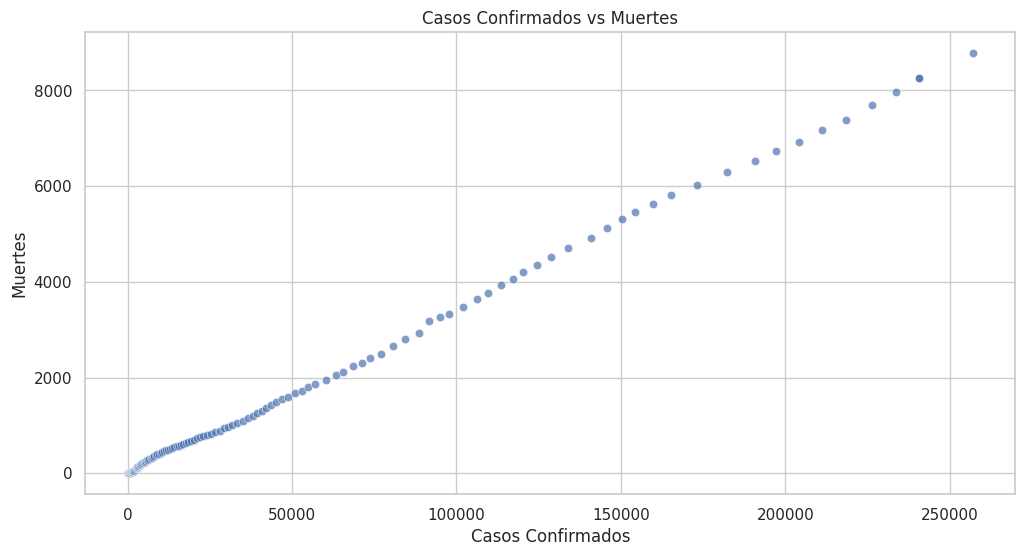

In [12]:
plt.figure(figsize=(12, 6))
sns.scatterplot(data = df_Colombia, x = 'Confirmed', y = 'Deaths', alpha=0.7)
plt.title('Casos Confirmados vs Muertes')
plt.xlabel('Casos Confirmados')
plt.ylabel('Muertes')
plt.show()

**Relación entre Casos Confirmados y Muertes por COVID-19**

La gráfica de dispersión evidencia una relación lineal positiva fuerte entre el número acumulado de casos confirmados y el número de muertes reportadas en Colombia. A medida que los casos aumentan, el número de fallecimientos también crece de forma proporcional, lo que sugiere una correlación directa y estable entre ambas variables.

Esta relación es esperable en una pandemia, donde el número de muertes guarda una dependencia directa con el volumen de contagios. La pendiente casi constante indica que la tasa de letalidad se mantuvo relativamente estable durante el periodo analizado, sin evidenciar quiebres bruscos ni comportamientos atípicos significativos.

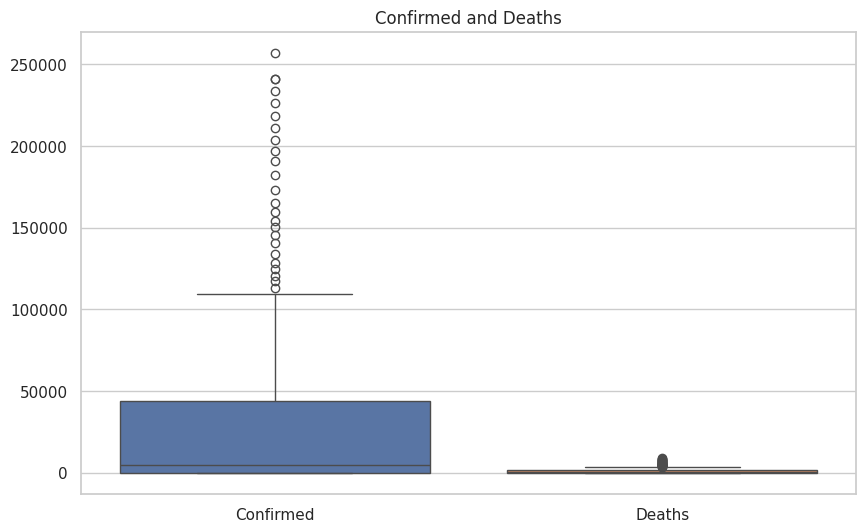

In [13]:
plt.figure(figsize=(10, 6))
sns.boxplot(data=df_Colombia[['Confirmed', 'Deaths']])
plt.title('Confirmed and Deaths')
plt.show()

En la visualización tipo boxplot se observa una marcada diferencia en la escala y variabilidad de las dos variables:

- Casos Confirmados presentan una amplia dispersión, con una gran cantidad de valores atípicos, muy por encima del rango intercuartílico, lo cual es consistente con los picos epidémicos registrados durante las fases más críticas de la pandemia.

- Muertes muestran una distribución mucho más concentrada, con menor variabilidad y una escala considerablemente menor, aunque también se evidencian algunos outliers.

Esta diferencia entre ambas variables refleja no solo su naturaleza epidemiológica (los contagios tienden a crecer más rápido y en mayor volumen que los fallecimientos), sino también la necesidad de aplicar técnicas de escalado o transformación en etapas posteriores de modelado para garantizar que ninguna variable domine el aprendizaje del modelo debido a su magnitud.

## Preprocesamiento de los Datos

In [14]:
df_Colombia = df_Colombia.drop(['Province/State', 'Lat', 'Long', 'WHO Region'], axis = 1)
df_Colombia = (df_Colombia
               .loc[:, ['Date', 'Confirmed', 'Deaths']]  #only interested in Confirmed/Deaths cases
               .set_index("Date")
                .diff()         #convert to daily cases
                .iloc[1:]       #remove first row, it is NaN to the .diff()
                .iloc[:-2]      #remove the last 2 rows
                )

Se buscará el análisis de los casos diarios y las muertes diarias para mayor efectos a la hora de hacer el análisis. Se hace la transformación de los datos acumulados a incrementos diario, ya que estos son más informativos para modelar el comportamiento diario. De igual manera se eliminan los registros negativos por errores o ajustes de reporte. Tambien se eliminan los dos ultimos registros, ya que presentaban errores como una cantidad de casos como 0, lo que afectaba negativamente el reporte.

In [15]:
df_Colombia["day_of_week"] = df_Colombia.index.dayofweek
df_Colombia["is_weekend"] = df_Colombia["day_of_week"].isin([5, 6]).astype(int)
df_Colombia["day_of_year"] = df_Colombia.index.dayofyear
df_Colombia["month"] = df_Colombia.index.month
df_Colombia["week_of_year"] = df_Colombia.index.isocalendar().week.astype(int)
df_Colombia["days_since_start"] = (df_Colombia.index - df_Colombia.index.min()).days

In [16]:
df_Colombia

,Confirmed,Deaths,day_of_week,is_weekend,day_of_year,month,week_of_year,days_since_start
Date,,,,,,,,
2020-01-23,0.0,0.0,3,0,23,1,4,0
2020-01-24,0.0,0.0,4,0,24,1,4,1
2020-01-25,0.0,0.0,5,1,25,1,4,2
2020-01-26,0.0,0.0,6,1,26,1,4,3
2020-01-27,0.0,0.0,0,0,27,1,5,4
...,...,...,...,...,...,...,...,...
2020-07-21,7033.0,237.0,1,0,203,7,30,180
2020-07-22,7390.0,207.0,2,0,204,7,30,181
2020-07-23,7945.0,315.0,3,0,205,7,30,182


El crear nuevos **Temporal Features** le permite a los modelos capturar patrones estacionales y ciclos semanales que pueden influir fuertemente en los reportes (ejemplo: subreportes los fines de semana o fiestas)

In [17]:
def create_temporal_features(df, target_type="Confirmed", n_lags=7, window=7):
    if target_type not in ("Confirmed", "Deaths"):
        raise ValueError("target_type must be 'Confirmed' or 'Deaths'")

    df = df.copy()

    # Base
    temporal_cols = [
        "day_of_week", "day_of_year", "month", "week_of_year",
        "days_since_start", "is_weekend"
    ]

    for col in temporal_cols:
        if col in df.columns:
            df[col] = df[col].shift(1)
        else:
            raise KeyError(f"Missing temporal column '{col}' in DataFrame")

    # Rolling stats
    shifted = df[target_type].shift(1)
    df[f"rolling_mean_{window}_{target_type}"] = shifted.rolling(window=window).mean()
    df[f"rolling_std_{window}_{target_type}"] = shifted.rolling(window=window).std()

    # Lags
    for lag in range(1, n_lags + 1):
        df[f"lag_{target_type}_{lag}"] = df[target_type].shift(lag)

    # Delta and Acceleration
    df[f"delta_{target_type}"] = df[f"lag_{target_type}_1"] - df[f"lag_{target_type}_2"]
    df[f"acceleration_{target_type}"] = (
        df[f"lag_{target_type}_1"] - 2 * df[f"lag_{target_type}_2"] + df[f"lag_{target_type}_3"]
    )

    # Slope of the last 7 days
    def slope(series):
        x = np.arange(len(series))
        if series.isnull().any():
            return np.nan
        return np.polyfit(x, series, 1)[0]

    df[f"slope_7d_{target_type}"] = (
        df[f"lag_{target_type}_1"].rolling(window=7).apply(slope, raw=False)
    )

    # Interacciones simples
    df[f"interaction_lag_day"] = df[f"lag_{target_type}_1"] * df["day_of_week"]
    df[f"interaction_growth_month"] = df[f"delta_{target_type}"] * df["month"]

    # Target
    df[f"target_{target_type}"] = df[target_type]

    # Clean
    df.drop(['Deaths', 'Confirmed'], axis=1, errors='ignore', inplace=True)
    df.dropna(inplace=True)

    return df


### Uso de Rolling Features
Se agregaron medias y desviaciones estándar móviles de 7 días tanto para casos confirmados como para muertes. Estas estadísticas suavizan la serie temporal y capturan la tendencia reciente, proporcionando al modelo una visión contextualizada del comportamiento pasado inmediato.

### Uso de Lag Features
Finalmente, se generaron características **lag_features** que representan los valores pasados de los casos confirmados y muertes durante los últimos 7 días. Estas variables permiten que el modelo aprenda las dependencias naturales en las series temporales, las cuales son esenciales para realizar buenas predicciones problemas de predicciones.

### Uso de Delta
Representa el cambio diario entre el valor del día anterior y el de hace dos días. Es una medida simple de la velocidad de crecimiento o decrecimiento.

### Uso de Acceleration
Corresponde a la segunda diferencia entre valores consecutivos, análoga a la segunda derivada en cálculo. Mide el ritmo de cambio del crecimiento (es decir, si el crecimiento se está acelerando o frenando).

### Uso de Slope en los ultimos 7 dias
Calcula la pendiente de una regresión lineal sobre los últimos 7 días de la serie. A diferencia del delta puntual, esta medida suaviza el ruido diario y capta la tendencia global de la semana.

### Uso de Interacciones diarias
Es una interacción entre el valor del día anterior (lag_1) y el día de la semana. Se incorporó para que el modelo pueda capturar patrones recurrentes asociados a días específicos (como subregistro en fines de semana).

### Uso de interacciones Mensuales
Combina el cambio diario (delta) con el mes del año. Se añade para capturar efectos estacionales o relacionados con la fase de la pandemia.

En resumen, estas variables no solo aumentan la dimensionalidad del modelo de manera informada, sino que también le brindan contexto temporal, tendencias locales y patrones, lo cual es fundamental en series temporales complejas como la de COVID-19. En conjunto, ayudan a que el modelo aprenda más allá de valores absolutos, permitiéndole anticipar cambios de dirección, aceleraciones y comportamientos estacionales.

In [18]:
df_confirmed = create_temporal_features(df_Colombia, target_type = "Confirmed", n_lags = 14, window = 7)
df_deaths = create_temporal_features(df_Colombia, target_type="Deaths", n_lags=7, window=7)

In [19]:
df_confirmed.head()

,day_of_week,is_weekend,day_of_year,month,week_of_year,days_since_start,rolling_mean_7_Confirmed,rolling_std_7_Confirmed,lag_Confirmed_1,lag_Confirmed_2,...,lag_Confirmed_11,lag_Confirmed_12,lag_Confirmed_13,lag_Confirmed_14,delta_Confirmed,acceleration_Confirmed,slope_7d_Confirmed,interaction_lag_day,interaction_growth_month,target_Confirmed
Date,,,,,,,,,,,,,,,,,,,,,
2020-02-06,2.0,0.0,36.0,2.0,6.0,13.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2020-02-07,3.0,0.0,37.0,2.0,6.0,14.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2020-02-08,4.0,0.0,38.0,2.0,6.0,15.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2020-02-09,5.0,1.0,39.0,2.0,6.0,16.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2020-02-10,6.0,1.0,40.0,2.0,6.0,17.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [20]:
df_deaths.head() 

,day_of_week,is_weekend,day_of_year,month,week_of_year,days_since_start,rolling_mean_7_Deaths,rolling_std_7_Deaths,lag_Deaths_1,lag_Deaths_2,...,lag_Deaths_4,lag_Deaths_5,lag_Deaths_6,lag_Deaths_7,delta_Deaths,acceleration_Deaths,slope_7d_Deaths,interaction_lag_day,interaction_growth_month,target_Deaths
Date,,,,,,,,,,,,,,,,,,,,,
2020-01-30,2.0,0.0,29.0,1.0,5.0,6.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2020-01-31,3.0,0.0,30.0,1.0,5.0,7.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2020-02-01,4.0,0.0,31.0,1.0,5.0,8.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2020-02-02,5.0,1.0,32.0,2.0,5.0,9.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2020-02-03,6.0,1.0,33.0,2.0,5.0,10.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


Se deja indicado el dataframe de Muertes diarias confirmadas, para el cual hay que seguir el mismo proceso que se utilizaŕa a continuacion.

## Modelos

### Funciones de Apoyo

In [21]:

def plot_predictions(model_name, y_train, y_test, y_pred):
    plt.figure(figsize=(12, 6))
    plt.plot(y_train.index, y_train, label="Train", color = 'blue')
    plt.plot(y_test.index, y_test, label = "Test - Real", color = 'orange')
    plt.plot(y_test.index, y_pred, label = "Test - Predicted", linestyle='--', color = 'green')
    plt.title(f"Predicción de Casos Diarios COVID-19 - {model_name}")
    plt.xlabel("Fecha")
    plt.ylabel("Casos Confirmados Diarios")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

In [22]:
def plot_feature_importance(model, X, top_n = 10):
    fi = pd.DataFrame({
            'Feature': X.columns,
            'Importance': model.feature_importances_
        }).sort_values(by='Importance', ascending=False)
        
    display(fi.head(top_n))

    plt.figure(figsize=(8, 5))
    plt.barh(fi['Feature'][:top_n][::-1], fi['Importance'][:top_n][::-1], color='steelblue')
    plt.title(f"Top {top_n} Feature Importances")
    plt.xlabel("Importance")
    plt.grid(True, linestyle='--', alpha=0.5)
    plt.tight_layout()
    plt.show()

In [23]:
model_results = {} 

Los resultados se guardarán aca, con el fin de posteriormente hacer un analisis detallado de todos los modelos

### Division de Datos

Empezaremos haciendo la division de los datos en entrenamiento y prueba. Haremos las predicciones en el ultimo mes que se tiene registro (julio 2020), asi que se tomarán los datos desde enero 2020 hasta junio 2020.

In [24]:
limit = pd.to_datetime('2020-07-01')

train = df_confirmed.loc["2020-01-30":"2020-06-30"]
test = df_confirmed.loc["2020-07-01":"2020-07-25"]

X_train = train.drop("target_Confirmed", axis=1)
y_train = train["target_Confirmed"]
X_test = test.drop("target_Confirmed", axis=1)
y_test = test["target_Confirmed"]

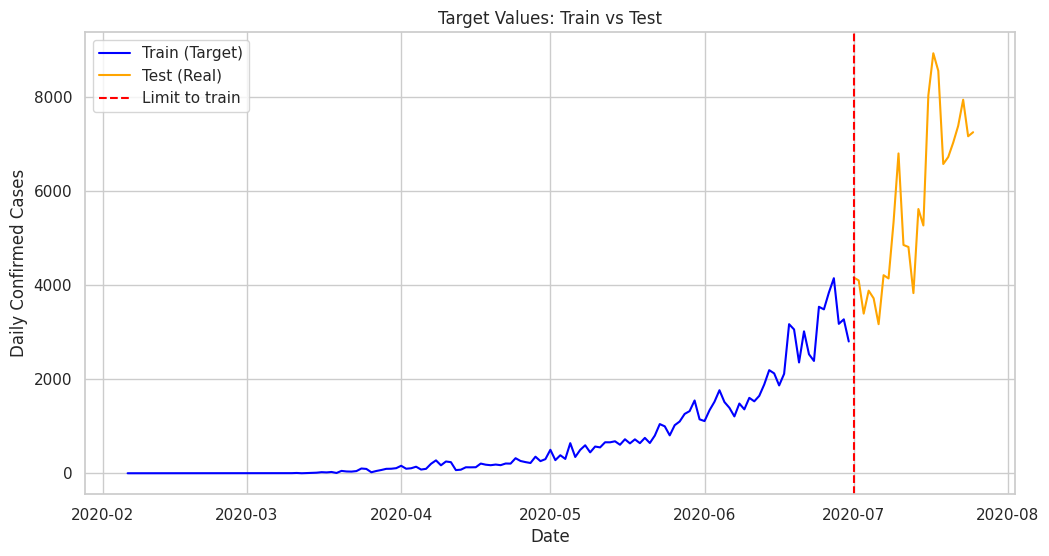

In [25]:
plt.figure(figsize=(12, 6))
plt.plot(y_train.index, y_train, label="Train (Target)", color="blue")
plt.plot(y_test.index, y_test, label="Test (Real)", color="orange") 
plt.axvline(x = limit, color='red', linestyle='--', label='Limit to train')
plt.legend()
plt.grid(True)
plt.title("Target Values: Train vs Test")
plt.xlabel("Date")
plt.ylabel("Daily Confirmed Cases")
plt.show()

Como podemos notar, se observa una aceleración exponencial de casos diarios confirmados entre junio y julio de 2020, lo que indica una **serie temporal no estacionaria** con una fuerte tendencia creciente y alta varianza en el conjunto de prueba.

### Escalado de Datos

In [26]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

y_train_scaled = scaler.fit_transform(y_train.values.reshape(-1, 1)).ravel()
y_test_scaled = scaler.transform(y_test.values.reshape(-1, 1)).ravel()

Utilizamos la clase StandardScaler() de la biblioteca scikit-learn, la cual realiza un escalado estándar. Este procedimiento transforma las variables de forma que tengan media cero y desviación estándar uno se aplicaron

- fit_transform() se aplica sobre el conjunto de entrenamiento para calcular la media y desviación estándar.

- transform() se aplica al conjunto de prueba usando los parámetros calculados sobre el entrenamiento.

- La variable objetivo (y) también fue escalada, ya que algunos modelos como el MLPRegressor son sensibles a la escala de salida y pueden beneficiarse de esta transformación.

Es importante mencionar que, si se desea interpretar las predicciones de los modelos en la escala original, se debe aplicar el proceso inverso utilizando inverse_transform() sobre los valores predichos, esto se implementó posteriormente en cada salida de los modelos que lo requieran.

In [27]:
tscv = TimeSeriesSplit(n_splits=5)

Se usa el TimeSeriesSplit para respetar el orden cronológico, ya que esta técnica permite dividir el conjunto de entrenamiento en bloques secuenciales de tiempo, de modo que cada conjunto de validación siempre contenga datos posteriores a los del conjunto de entrenamiento. De esta manera, se simula de forma más realista cómo el modelo haría predicciones en el futuro usando solo información del pasado, lo cual es coherente con el comportamiento real de las series temporales.

### Métrica principal: MAE (Mean Absolute Error)

In [28]:
scoring_metric = 'neg_mean_absolute_error'

Escogemos esat métrica porque, refleja el error absoluto, es decir, los errores se traducen en decisiones en la confirmacion de los casos, ademas que penaliza grandes errores con cautela, manteniendo unas buenas metricas en general, esto se calcula sumando las diferencias absolutas entre cada valor predicho y el valor real, y luego dividiendo esa suma por el número total de observaciones

$$
MAE = \frac{1}{n} \sum_{i=1}^{n} \left| y_i - \hat{y}_i \right|
$$

Donde:
- $n$: es elnúmero total de observaciones  
- $y_i$: es el valor real  
- $\hat{y}_i$: es el valor predicho

### Linear Regression

No tiene hiperparametros para buscar por medio del Grid Search, por ende, se omitirá ese paso en este modelo.

In [29]:
lr = LinearRegression()
lr.fit(X_train_scaled, y_train_scaled)

LinearRegression()

In [30]:
y_pred_lr_scaled = lr.predict(X_test_scaled)
y_pred_lr = scaler.inverse_transform(y_pred_lr_scaled.reshape(-1, 1)).ravel()

mae_lr = mean_absolute_error(y_test, y_pred_lr)
mse_lr = mean_squared_error(y_test, y_pred_lr)
rmse_lr = np.sqrt(mean_squared_error(y_test, y_pred_lr))
r2_lr = r2_score(y_test, y_pred_lr)

In [31]:
model_results["Linear Regression"] = {
    "model": lr,
    "MAE": mae_lr,
    "MSE": mse_lr,
    "RMSE": rmse_lr,
    "R2": r2_lr,
    "y_pred": y_pred_lr
}

In [32]:
print("Linear Regression")
print(f"MAE:  {mae_lr:.2f}")
print(f"MSE: {mse_lr:.2f}")
print(f"RMSE: {rmse_lr:.2f}")
print(f"R²:   {r2_lr:.4f}")

Linear Regression
MAE:  1275.11
MSE: 2664996.38
RMSE: 1632.48
R²:   0.1136


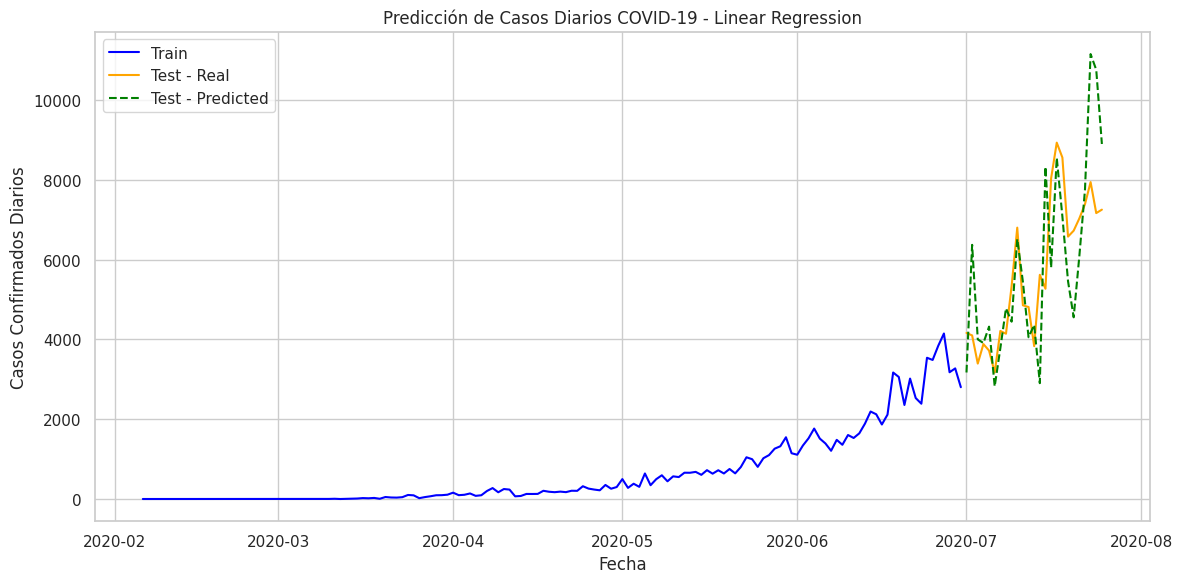

In [33]:
plot_predictions("Linear Regression", y_train, y_test, y_pred_lr)

### Decision Tree

**Detalle de los parámetros**

max_depth:
Profundidad máxima permitida del árbol.

- 5, 10, 20: limitan el crecimiento del árbol para evitar sobreajuste en datos ruidosos o pequeños.

- None: permite que el árbol crezca hasta que todas las hojas sean puras o contengan menos muestras que min_samples_split.

min_samples_split:
Mínimo número de muestras requerido para dividir un nodo interno.

- Valores más altos impiden que el árbol crezca demasiado rápido, reduciendo el riesgo de sobreajuste.

- Por ejemplo, 10 fuerza a que los nodos tengan al menos 10 muestras para dividirse.

min_samples_leaf:
Número mínimo de muestras requeridas para estar en una hoja.

- 1: hojas pueden contener una sola muestra (modelo muy detallado, potencialmente sobreajustado).

- 2: cada hoja debe tener al menos dos muestras, lo que aporta mayor estabilidad al árbol.

In [34]:
param_dt = {
    'max_depth': [5, 10, 20, None],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2]
}

grid_dt = GridSearchCV(
    DecisionTreeRegressor(random_state=42),
    param_grid = param_dt,
    scoring = scoring_metric,
    cv = tscv,
    n_jobs = -1
)

grid_dt.fit(X_train_scaled, y_train)

GridSearchCV(cv=TimeSeriesSplit(gap=0, max_train_size=None, n_splits=5, test_size=None),
             estimator=DecisionTreeRegressor(random_state=42), n_jobs=-1,
             param_grid={'max_depth': [5, 10, 20, None],
                         'min_samples_leaf': [1, 2],
                         'min_samples_split': [2, 5, 10]},
             scoring='neg_mean_absolute_error')

In [35]:
y_pred_dt = grid_dt.predict(X_test_scaled)

mae_dt = mean_absolute_error(y_test, y_pred_dt)
mse_dt = mean_squared_error(y_test, y_pred_dt)
rmse_dt = np.sqrt(mean_squared_error(y_test, y_pred_dt))
r2_dt = r2_score(y_test, y_pred_dt)

In [36]:
model_results["Decision Tree"] = {
    "model": grid_dt.best_estimator_,
    "MAE": mae_dt,
    "MSE": mse_dt,
    "RMSE": rmse_dt,
    "R2": r2_dt,
    "y_pred": y_pred_dt,
    "best_params": grid_dt.best_params_
}

print("Decision Tree")
print("Mejores parámetros:", grid_dt.best_params_)
print(f"MAE:  {mae_dt:.2f}")
print(f"MSE: {mse_dt:.2f}")
print(f"RMSE: {rmse_dt:.2f}")
print(f"R²:   {r2_dt:.4f}")

Decision Tree
Mejores parámetros: {'max_depth': 10, 'min_samples_leaf': 1, 'min_samples_split': 2}
MAE:  1913.68
MSE: 6001552.56
RMSE: 2449.81
R²:   -0.9962


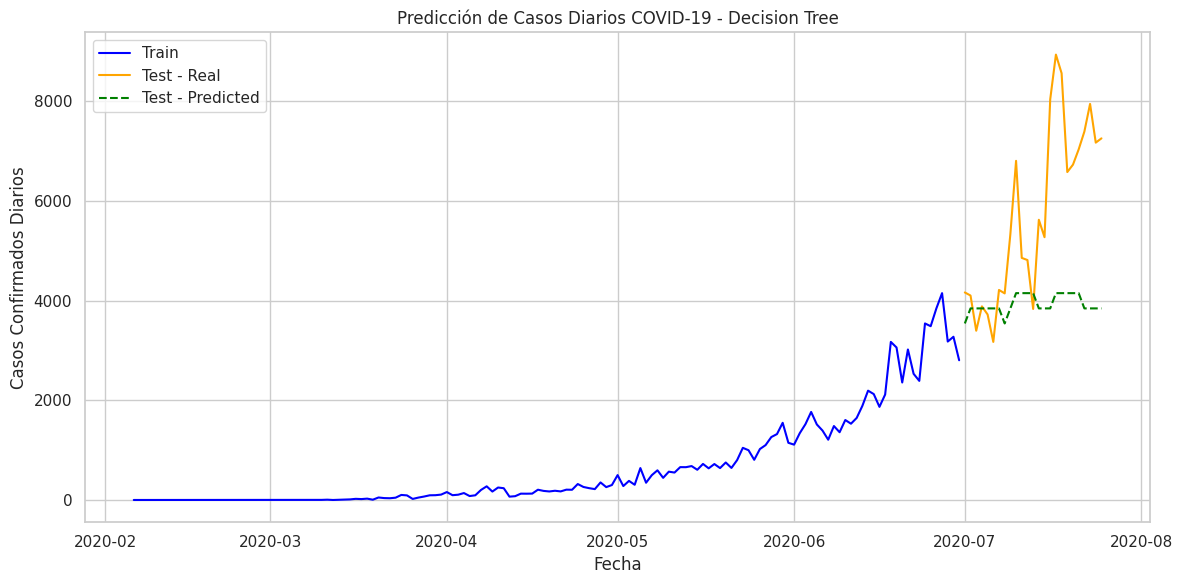

In [37]:
plot_predictions("Decision Tree", y_train, y_test, y_pred_dt)

,Feature,Importance
14,lag_Confirmed_7,0.822845
11,lag_Confirmed_4,0.123638
2,day_of_year,0.011650
15,lag_Confirmed_8,0.011461
8,lag_Confirmed_1,0.009676
21,lag_Confirmed_14,0.005651
17,lag_Confirmed_10,0.005578
24,slope_7d_Confirmed,0.002211
22,delta_Confirmed,0.001831
10,lag_Confirmed_3,0.001172


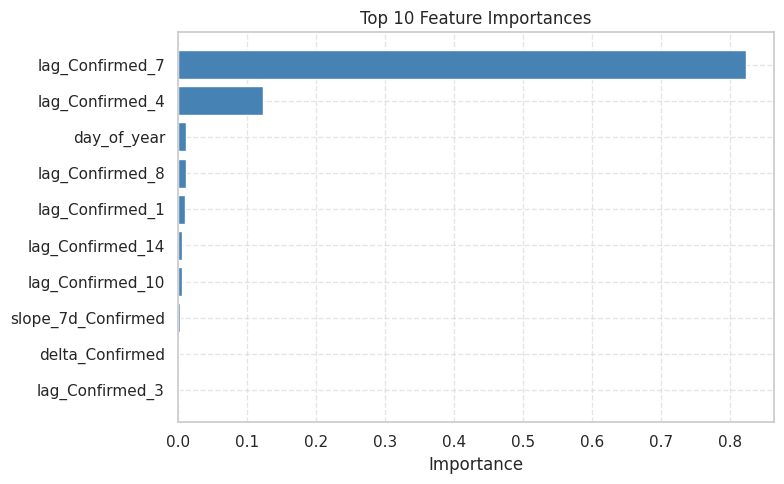

In [38]:
plot_feature_importance(grid_dt.best_estimator_, X_train, top_n=10)

Aca podemos observar que el modelo, tiene como caracteristicas mas importante el lag_Confirmed_7, que fue una caracteristica que se le agrego manualmente. Demostrando que el uso de esta si esta siendo util para los modelos.

### Random Forest

**Detalle de los parámetros**

n_estimators:
Número de árboles en el bosque.

- 100 y 200 son valores comunes que ofrecen un buen equilibrio entre rendimiento y tiempo de entrenamiento.

- Más árboles tienden a mejorar la estabilidad y precisión del modelo, pero aumentan el costo computacional.

max_depth:
Profundidad máxima de cada árbol.

- 10, 20 y 50 limitan la profundidad para evitar sobreajuste.

- None permite que los árboles crezcan hasta que todas las hojas sean puras (potencial sobreajuste si no se controla).

min_samples_split:
Número mínimo de muestras requeridas para dividir un nodo interno.

- Valores bajos (2, 5) permiten árboles más complejos, pero pueden generar sobreajuste si no se acompañan de otros controles.

min_samples_leaf:
Número mínimo de muestras requeridas en una hoja.

- 1 permite alta complejidad; 2 fuerza una pequeña generalización adicional, ayudando a suavizar los resultados.

max_features:
Número de características consideradas al dividir un nodo.

- 'sqrt' (raíz cuadrada del número total de características) es el valor por defecto en regresión, y favorece la diversidad entre árboles, mejorando la capacidad de generalización del modelo.

In [39]:
param_rf = {
    'n_estimators': [100, 200],
    'max_depth': [10, 20, 50, None],
    'min_samples_split': [2, 5],
    'min_samples_leaf': [1, 2],
    'max_features': ['sqrt']
}

grid_rf = GridSearchCV(
    RandomForestRegressor(random_state=42),
    param_grid = param_rf,
    scoring = scoring_metric,
    cv = tscv,
    n_jobs = -1
)

grid_rf.fit(X_train_scaled, y_train)

GridSearchCV(cv=TimeSeriesSplit(gap=0, max_train_size=None, n_splits=5, test_size=None),
             estimator=RandomForestRegressor(random_state=42), n_jobs=-1,
             param_grid={'max_depth': [10, 20, 50, None],
                         'max_features': ['sqrt'], 'min_samples_leaf': [1, 2],
                         'min_samples_split': [2, 5],
                         'n_estimators': [100, 200]},
             scoring='neg_mean_absolute_error')

In [40]:
y_pred_rf = grid_rf.predict(X_test_scaled)

mae_rf = mean_absolute_error(y_test, y_pred_rf)
mse_rf = mean_squared_error(y_test, y_pred_rf)
rmse_rf = np.sqrt(mean_squared_error(y_test, y_pred_rf))
r2_rf = r2_score(y_test, y_pred_rf)

In [41]:
model_results["Random Forest"] = {
    "model": grid_rf.best_estimator_,
    "MAE": mae_rf,
    "MSE": mse_rf,
    "RMSE": rmse_rf,
    "R2": r2_rf,
    "y_pred": y_pred_rf,
    "best_params": grid_rf.best_params_
}

print("Random Forest")
print("Mejores parametros:", grid_rf.best_params_)
print(f"MAE:  {mae_rf:.2f}")
print(f"MSE: {mse_rf:.2f}")
print(f"RMSE: {rmse_rf:.2f}")
print(f"R²:   {r2_rf:.4f}")

Random Forest
Mejores parametros: {'max_depth': 10, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 100}
MAE:  2305.20
MSE: 8136269.18
RMSE: 2852.41
R²:   -1.7062


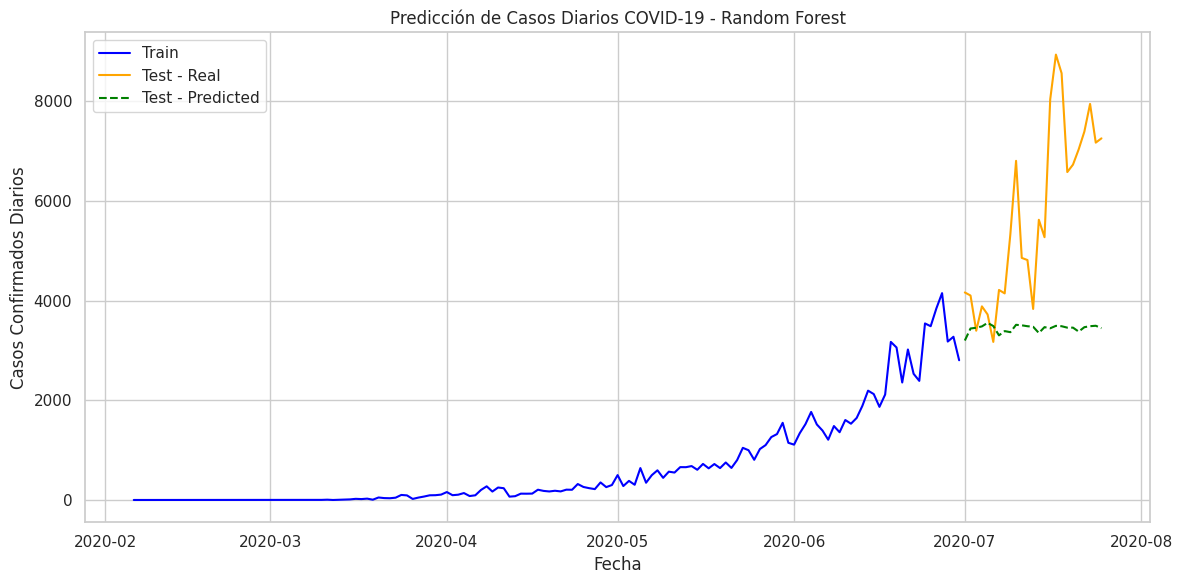

In [42]:
plot_predictions("Random Forest", y_train, y_test, y_pred_rf)

,Feature,Importance
2,day_of_year,0.112062
5,days_since_start,0.099448
6,rolling_mean_7_Confirmed,0.097852
8,lag_Confirmed_1,0.097005
14,lag_Confirmed_7,0.095528
11,lag_Confirmed_4,0.060501
12,lag_Confirmed_5,0.056727
13,lag_Confirmed_6,0.053028
19,lag_Confirmed_12,0.052573
9,lag_Confirmed_2,0.051834


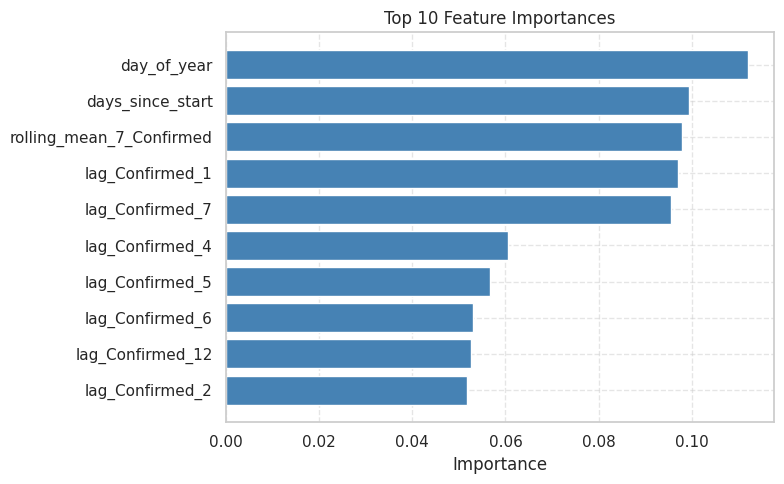

In [43]:
plot_feature_importance(grid_rf.best_estimator_, X_train, top_n=10)

### Red Neuronal

**Detalle de los parámetros**

hidden_layer_sizes:
Define la arquitectura de la red neuronal, es decir, el número de capas ocultas y neuronas en cada capa.

- (50,) y (100,): redes con una sola capa oculta de 50 o 100 neuronas.

- (64, 64): dos capas ocultas, cada una con 64 neuronas.

- (128, 64): una arquitectura más profunda, con 128 neuronas en la primera capa y 64 en la segunda.

- Se exploran diferentes configuraciones para equilibrar la capacidad de aprendizaje y evitar el sobreajuste.

activation:
Función de activación usada en las capas ocultas:

- 'relu': común en redes profundas por su eficiencia computacional y buena convergencia.

- 'tanh': útil cuando los datos están centrados en cero; puede funcionar mejor en algunos contextos de series temporales.

solver:
Algoritmo para optimizar los pesos de la red:

- 'adam': adaptativo y eficiente para problemas grandes; buena opción por defecto.

- 'sgd': descenso de gradiente estocástico clásico, útil pero más sensible a los hiperparámetros (como la tasa de aprendizaje).

learning_rate_init:
Tasa de aprendizaje inicial:

- Se prueban valores pequeños (0.001) hasta moderados (0.1) para observar el efecto sobre la velocidad de convergencia y la estabilidad del entrenamiento.

max_iter:
Número máximo de iteraciones durante el entrenamiento:

- Se permiten hasta 4000 iteraciones para asegurar convergencia en configuraciones más complejas

In [44]:
warnings.filterwarnings("ignore")

param_mlp = {
    'hidden_layer_sizes': [(50,), (100,), (64, 64), (128, 64)],
    'activation': ['relu', 'tanh'],
    'solver': ['adam', 'sgd'],
    'learning_rate_init': [0.001, 0.01, 0.1],
    'max_iter': [2000, 4000]
}


grid_mlp = GridSearchCV(
    MLPRegressor(random_state=42, early_stopping=True, n_iter_no_change=15),
    param_grid = param_mlp,
    scoring = scoring_metric,
    cv = tscv,
    n_jobs = -1
)
grid_mlp.fit(X_train_scaled, y_train_scaled)

/home/dexx77/sh/Programming/AI/AI-Unimag/covid-19/datavnv/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (2000) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/dexx77/sh/Programming/AI/AI-Unimag/covid-19/datavnv/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (4000) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/dexx77/sh/Programming/AI/AI-Unimag/covid-19/datavnv/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (2000) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/dexx77/sh/Programming/AI/AI-Unimag/covid-19/datavnv/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochast

GridSearchCV(cv=TimeSeriesSplit(gap=0, max_train_size=None, n_splits=5, test_size=None),
             estimator=MLPRegressor(early_stopping=True, n_iter_no_change=15,
                                    random_state=42),
             n_jobs=-1,
             param_grid={'activation': ['relu', 'tanh'],
                         'hidden_layer_sizes': [(50,), (100,), (64, 64),
                                                (128, 64)],
                         'learning_rate_init': [0.001, 0.01, 0.1],
                         'max_iter': [2000, 4000], 'solver': ['adam', 'sgd']},
             scoring='neg_mean_absolute_error')

In [45]:
y_pred_mlp_scaled = grid_mlp.predict(X_test_scaled)
y_pred_mlp = scaler .inverse_transform(y_pred_mlp_scaled.reshape(-1, 1)).ravel()

mae_mlp  = mean_absolute_error(y_test, y_pred_mlp)
mse_mlp = mean_squared_error(y_test, y_pred_mlp)
rmse_mlp = np.sqrt(mean_squared_error(y_test, y_pred_mlp))
r2_mlp   = r2_score(y_test, y_pred_mlp)

In [46]:
model_results["MLPRegressor"] = {
    "model": grid_mlp.best_estimator_,
    "MAE": mae_mlp,
    "MSE": mse_mlp,
    "RMSE": rmse_mlp,
    "R2": r2_mlp,
    "y_pred": y_pred_mlp,
    "best_params": grid_mlp.best_params_
}

print("MLPRegressor")
print("Mejores parametros:", grid_mlp.best_params_)
print(f"MAE:  {mae_mlp:.2f}")
print(f"MSE: {mse_mlp:.2f}")
print(f"RMSE: {rmse_mlp:.2f}")
print(f"R²:   {r2_mlp:.4f}")

MLPRegressor
Mejores parametros: {'activation': 'relu', 'hidden_layer_sizes': (100,), 'learning_rate_init': 0.001, 'max_iter': 2000, 'solver': 'adam'}
MAE:  983.06
MSE: 1462377.38
RMSE: 1209.29
R²:   0.5136


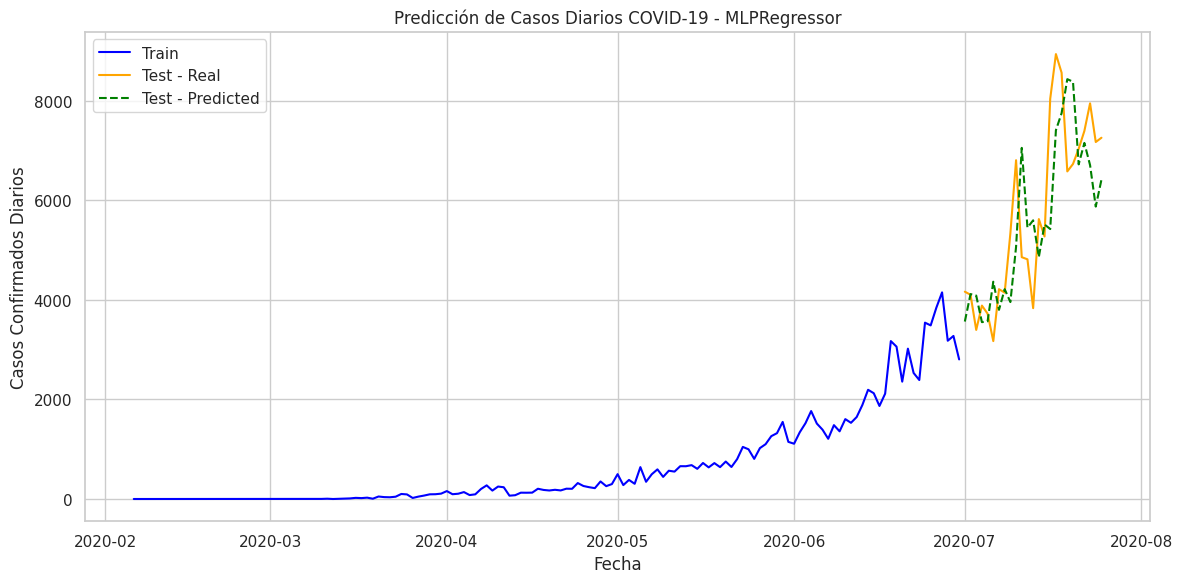

In [47]:
plot_predictions("MLPRegressor", y_train, y_test, y_pred_mlp)

## Comparación entre Modelos

Se harán las comparativas entre todos los modelos que se entrenaron y las respectivas metricas sobre los resultados de los mismos

In [48]:
metrics_df = pd.DataFrame({
    model: {
        "MAE": results["MAE"],
        "MSE": results["MSE"],
        "RMSE": results["RMSE"],
        "R²": results["R2"]
    }
    for model, results in model_results.items()
}).T

metrics_df = metrics_df.sort_values(by="MAE")
metrics_df

,MAE,MSE,RMSE,R²
MLPRegressor,983.056589,1.462377e+06,1209.287964,0.513603
Linear Regression,1275.107976,2.664996e+06,1632.481663,0.113603
Decision Tree,1913.680000,6.001553e+06,2449.806637,-0.996160
Random Forest,2305.202800,8.136269e+06,2852.414623,-1.706183


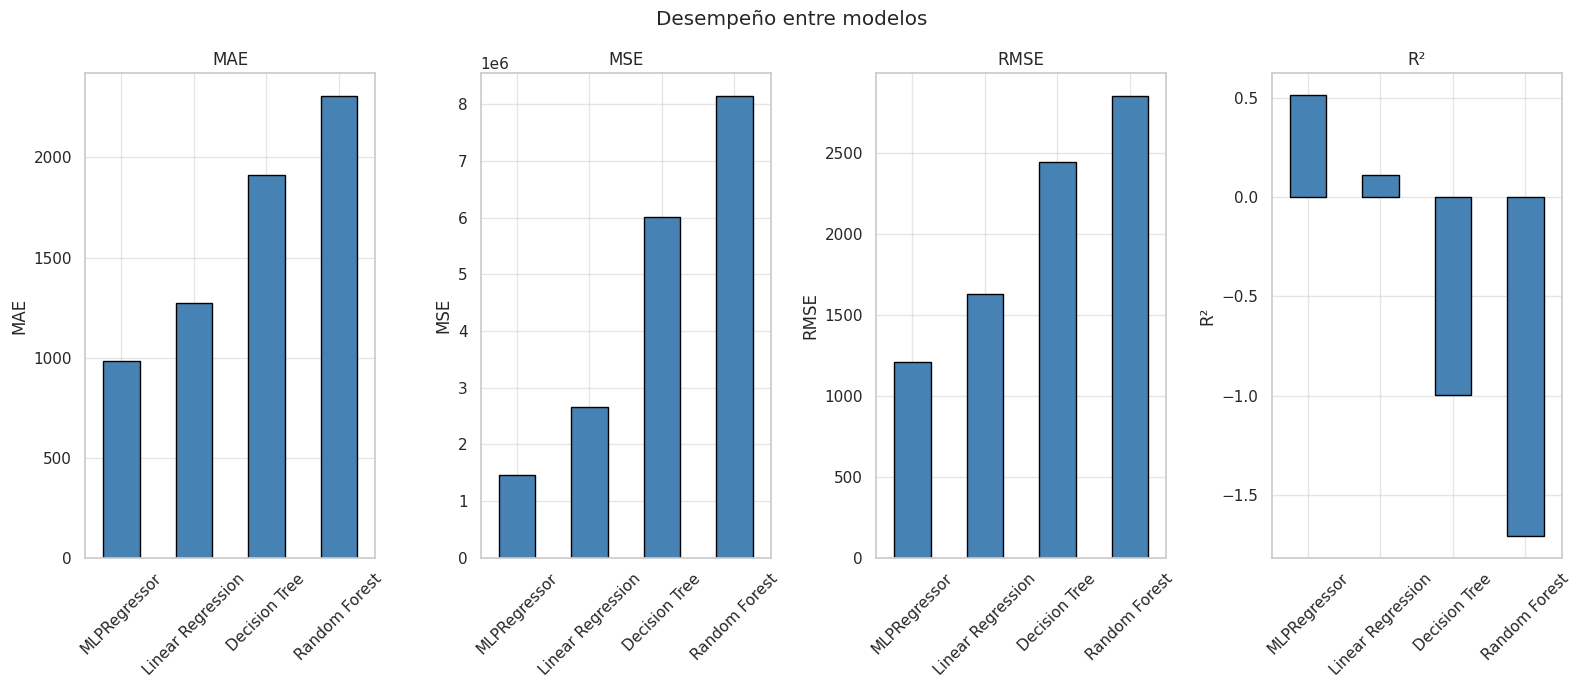

In [49]:
plt.figure(figsize=(16, 7))

for i, metric in enumerate(["MAE", "MSE","RMSE", "R²"], 1):
    plt.subplot(1, 4, i)
    metrics_df[metric].plot(kind='bar', title=metric, color='steelblue', edgecolor='black')
    plt.ylabel(metric)
    plt.xticks(rotation=45)
    plt.grid(True, alpha=0.5)

plt.suptitle("Desempeño entre modelos")
plt.tight_layout()
plt.show()

## Interpretación de los resultados

1. **MLPRegressor** — Mejor desempeño global

    Con un MAE de 983 casos diarios, es el modelo que presenta menor error absoluto promedio. La RMSE de 1209 es también la más baja, indicando baja dispersión de los errores. Su score en R² = 0.51 indica que el modelo explica más del 51% de la variabilidad en los casos diarios reales. Tambien captura de buena manera el crecimiento acelerado observado en julio, gracias a su capacidad de modelar relaciones no lineales complejas.

    Uno de los puntos claves del modelo fue mejorarlo con estrategias como:

    - Escalado del target (y_train)

    - GridSearchCV con early stopping

    - Ajuste fino de hiperparámetros ((100,), relu, adam)

2. **Regresión Lineal Multivariada**

    Aunque es un modelo simple, logró un rendimiento notablemente robusto, superando ampliamente a los modelos de árboles. MAE de 1275 y un R² positivo (0.11) muestran que logra capturar parte del patrón de crecimiento, especialmente en periodos con comportamiento más lineal. Su bajo sesgo y facilidad de interpretación lo hacen una buena opción base como fue su objetivo en este notebook, ya que es un modelo sencillo.

3. **Árbol de Decisión**

    MAE y RMSE significativamente más altos (1913, 2449) y un R² de -0.99, reflejan un modelo que memoriza pero no generaliza. Muestra signos claros de overfitting al entrenamiento. Pero a pesar de intentar controlar este overfitting, se encontro por el contrario un underfitting, siendo ambos resultados inesperados en este ejercicio, ya que carecen de la capacidad para extrapolar tendencias crecientes. Su estructura segmentada no es adecuada para series temporales con comportamiento continuo y acelerado.

4. **Random Forest**

    El peor desempeño general: MAE de 2305 y R² de -1.71, lo que significa que predecir la media constante habría sido mejor. Aunque es poderoso en clasificación y regresión en datos tabulares, su incapacidad para extrapolar valores fuera del rango observado lo penaliza fuertemente en esta serie temporal. La predicción fue conservadora y al parecer, no siguió el crecimiento exponencial de los casos.

**Conclusion General**

- El modelo MLPRegressor, correctamente ajustado, es el único que logra predecir con precisión razonable el brote de COVID-19 en Colombia durante julio de 2020.

- La regresión lineal sirve como baseline confiable, especialmente cuando los datos son limitados o ruidosos.

- Los modelos basados en árboles demostraron no ser adecuados para este tipo de series temporales con crecimiento acelerado, debido a su carencia de extrapolación y sensibilidad al rango de entrenamiento. Ya que les cuesta demasiado extrapolar hacia regiones no vistas del espacio de entrenamiento. Simplemente "no imagina" crecimientos nuevos, esto puede deberse mucho a la poca cantidad de datos que existe en el dataset, a estos modelos les costó mucho llegar a generalizar con una cantidad de datos tan pobre.

**Futuro Trabajo**

Para futuros modelos de predicción de variables, en ejercicios como este con comportamiento exponencial o no lineal, se recomienda:

- Utilizar redes neuronales con técnicas de regularización y escalado adecuado.

- Encontrar un mejor conjunto de datos sobe el COVID-19 en Colombia, con mas datos y mejor calidad de los mismos.

- Aumentar la longitud de la serie histórica con nuevas variables (movilidad, clima, intervenciones).

- Usar enfoques híbridos: redes recurrentes (RNN/LSTM), modelos neuronales con capas convolucionales, o aprendizaje profundo específico para series temporales (como Temporal Fusion Transformers).

- Usar modelos para series temporales como ARIMA, SARIMAX o Prophet de Meta.